### IMPORTS

In [17]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import glob

# Import our models
from models.lstm_model import StockLSTMModel, test_stationarity, TradingAdvisor
from models.lstm_model import plot_training_history, plot_predictions

print("All imports successful!")
print(f"Current working directory: {os.getcwd()}")


All imports successful!
Current working directory: d:\bootcamp ML\FINALPROJECT\financial_forecasting_project\notebooks


## CONFIGURATION SETUP


In [18]:
# Stock configuration
STOCKS = {
    'JKSE': 'IDX Composite',
    'BBCA': 'Bank Central Asia', 
    'BBRI': 'Bank Rakyat Indonesia',
    'TLKM': 'Telkom Indonesia',
    'ASII': 'Astra International',
    'UNVR': 'Unilever Indonesia'
}

# Training configuration
SEQUENCE_LENGTH = 60
FEATURES = ['Close', 'Volume', 'SMA_10', 'SMA_20', 'RSI', 'Volatility']
EPOCHS = 50
BATCH_SIZE = 32

# Paths
DATA_PATH = '../data/processed'
MODEL_PATH = '../models/saved_models'
REPORTS_PATH = '../reports'
FIGURES_PATH = '../reports/figures'

# Create directories
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

print(f"Configuration loaded:")
print(f"- Sequence Length: {SEQUENCE_LENGTH}")
print(f"- Features: {len(FEATURES)}")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch Size: {BATCH_SIZE}")

Configuration loaded:
- Sequence Length: 60
- Features: 6
- Epochs: 50
- Batch Size: 32


## DATA LOADING WITH COMPREHENSIVE CLEANING


In [19]:
def clean_numeric_column(series, column_name):
    """Clean a pandas series to ensure it's purely numeric"""
    original_len = len(series)
    
    # Convert to string first to identify non-numeric values
    str_series = series.astype(str)
    
    # Pattern for numeric values (including scientific notation)
    numeric_pattern = r'^-?\d*\.?\d+([eE][-+]?\d+)?$'
    is_numeric = str_series.str.match(numeric_pattern, na=False)
    
    # Find problematic values
    problematic = series[~is_numeric & series.notna()]
    if len(problematic) > 0:
        print(f"     Removing {len(problematic)} non-numeric values from {column_name}")
        print(f"     Examples: {list(problematic.unique())[:3]}")
    
    # Keep only numeric values
    clean_series = series[is_numeric]
    clean_series = pd.to_numeric(clean_series, errors='coerce')
    clean_series = clean_series.dropna()
    
    print(f"     {column_name}: {original_len} -> {len(clean_series)} values")
    return clean_series

def load_and_clean_data():
    """Load and comprehensively clean stock data"""
    stock_data = {}
    
    # Data file mapping
    data_files = {
        'JKSE': 'JKSE_processed.csv',
        'BBCA': 'BBCA_processed.csv', 
        'BBRI': 'BBRI_processed.csv',
        'TLKM': 'TLKM_processed.csv',
        'ASII': 'ASII_processed.csv',
        'UNVR': 'UNVR_processed.csv'
    }
    
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'SMA_20', 'RSI', 'Volatility', 'Returns']
    
    for symbol, filename in data_files.items():
        filepath = os.path.join(DATA_PATH, filename)
        
        try:
            if not os.path.exists(filepath):
                print(f"File not found: {filepath}")
                continue
                
            print(f"\nProcessing {STOCKS[symbol]} ({symbol}):")
            
            # Load raw data
            data = pd.read_csv(filepath, index_col=0)
            print(f"   Loaded: {data.shape[0]} rows, {data.shape[1]} columns")
            
            # Clean numeric columns
            cleaned_data = data.copy()
            rows_to_keep = pd.Series(True, index=data.index)
            
            for col in numeric_columns:
                if col in data.columns:
                    # Check for non-numeric values
                    str_series = data[col].astype(str)
                    numeric_pattern = r'^-?\d*\.?\d+([eE][-+]?\d+)?$'
                    is_numeric = str_series.str.match(numeric_pattern, na=False) | data[col].isna()
                    
                    # Mark rows with non-numeric values for removal
                    rows_to_keep &= is_numeric
                    
                    # Convert to numeric
                    cleaned_data[col] = pd.to_numeric(data[col], errors='coerce')
            
            # Keep only rows where all numeric columns are valid
            cleaned_data = cleaned_data[rows_to_keep]
            cleaned_data = cleaned_data.dropna(subset=numeric_columns)
            
            print(f"   After cleaning: {len(cleaned_data)} rows")
            
            # Convert index to datetime
            try:
                cleaned_data.index = pd.to_datetime(cleaned_data.index, errors='coerce')
                cleaned_data = cleaned_data[cleaned_data.index.notna()]
                print(f"   Date parsing successful: {len(cleaned_data)} rows")
            except:
                print(f"   Warning: Could not parse dates for {symbol}")
            
            # Final validation
            if len(cleaned_data) >= 100:  # Minimum data requirement
                stock_data[symbol] = cleaned_data
                print(f"   SUCCESS: {STOCKS[symbol]} ready for analysis")
                print(f"   Date range: {cleaned_data.index[0]} to {cleaned_data.index[-1]}")
            else:
                print(f"   SKIPPED: Insufficient data ({len(cleaned_data)} rows)")
                
        except Exception as e:
            print(f"   ERROR processing {symbol}: {str(e)}")
            continue
    
    return stock_data

# Load data
print("LOADING AND CLEANING DATA")
print("=" * 60)
stock_data = load_and_clean_data()
print(f"\nSuccessfully loaded {len(stock_data)} stocks")

LOADING AND CLEANING DATA

Processing IDX Composite (JKSE):
   Loaded: 1213 rows, 15 columns
   After cleaning: 1091 rows
   Date parsing successful: 1091 rows
   SUCCESS: IDX Composite ready for analysis
   Date range: 2020-02-27 00:00:00 to 2024-12-30 00:00:00

Processing Bank Central Asia (BBCA):
   Loaded: 1213 rows, 15 columns
   After cleaning: 1170 rows
   Date parsing successful: 1170 rows
   SUCCESS: Bank Central Asia ready for analysis
   Date range: 2020-01-30 00:00:00 to 2024-12-30 00:00:00

Processing Bank Rakyat Indonesia (BBRI):
   Loaded: 1213 rows, 15 columns
   After cleaning: 1191 rows
   Date parsing successful: 1191 rows
   SUCCESS: Bank Rakyat Indonesia ready for analysis
   Date range: 2020-01-30 00:00:00 to 2024-12-30 00:00:00

Processing Telkom Indonesia (TLKM):
   Loaded: 1213 rows, 15 columns
   After cleaning: 1171 rows
   Date parsing successful: 1171 rows
   SUCCESS: Telkom Indonesia ready for analysis
   Date range: 2020-01-30 00:00:00 to 2024-12-30 00:00

## DATA QUALITY SUMMARY


In [20]:
if stock_data:
    print("\nDATA QUALITY SUMMARY")
    print("=" * 60)
    
    for symbol, data in stock_data.items():
        print(f"\n{STOCKS[symbol]} ({symbol}):")
        
        # Date range
        if isinstance(data.index, pd.DatetimeIndex):
            print(f"  Period: {data.index[0].date()} to {data.index[-1].date()}")
        else:
            print(f"  Period: {data.index[0]} to {data.index[-1]}")
            
        print(f"  Records: {len(data):,}")
        print(f"  Missing values: {data.isnull().sum().sum()}")
        
        # Price info
        if 'Close' in data.columns:
            current_price = data['Close'].iloc[-1]
            print(f"  Latest price: IDR {current_price:,.0f}")
            
        # Feature availability
        available_features = [feat for feat in FEATURES if feat in data.columns]
        missing_features = [feat for feat in FEATURES if feat not in data.columns]
        
        print(f"  Available features: {len(available_features)}/{len(FEATURES)}")
        if missing_features:
            print(f"  Missing features: {missing_features}")
            
        # Data types check
        numeric_check = all(data[feat].dtype in ['float64', 'float32', 'int64', 'int32'] for feat in available_features)
        print(f"  Data types valid: {'Yes' if numeric_check else 'No'}")

else:
    print("No data loaded successfully. Please check your data files.")
    sys.exit(1)


DATA QUALITY SUMMARY

IDX Composite (JKSE):
  Period: 2020-02-27 to 2024-12-30
  Records: 1,091
  Missing values: 150
  Latest price: IDR 7,080
  Available features: 6/6
  Data types valid: Yes

Bank Central Asia (BBCA):
  Period: 2020-01-30 to 2024-12-30
  Records: 1,170
  Missing values: 59
  Latest price: IDR 9,386
  Available features: 6/6
  Data types valid: Yes

Bank Rakyat Indonesia (BBRI):
  Period: 2020-01-30 to 2024-12-30
  Records: 1,191
  Missing values: 29
  Latest price: IDR 3,856
  Available features: 6/6
  Data types valid: Yes

Telkom Indonesia (TLKM):
  Period: 2020-01-30 to 2024-12-30
  Records: 1,171
  Missing values: 59
  Latest price: IDR 2,512
  Available features: 6/6
  Data types valid: Yes

Astra International (ASII):
  Period: 2020-01-30 to 2024-12-30
  Records: 1,171
  Missing values: 59
  Latest price: IDR 4,589
  Available features: 6/6
  Data types valid: Yes

Unilever Indonesia (UNVR):
  Period: 2020-01-30 to 2024-12-30
  Records: 1,151
  Missing values

## STATIONARITY TESTING

In [22]:
print("\nSTATIONARITY TESTING")
print("=" * 60)

stationarity_results = {}

for symbol, data in stock_data.items():
    print(f"\nTesting {STOCKS[symbol]} ({symbol})")
    print("-" * 40)
    
    try:
        # Test close prices
        if 'Close' in data.columns:
            close_series = data['Close'].dropna()
            
            if len(close_series) >= 50:
                print(f"   Testing Close prices ({len(close_series)} points)")
                result_close = test_stationarity(close_series, f"{STOCKS[symbol]} - Close Price")
                stationarity_results[f"{symbol}_close"] = result_close
            else:
                print(f"   Insufficient close price data: {len(close_series)}")
        
        # Test returns
        if 'Returns' in data.columns:
            returns_series = data['Returns'].dropna()
            
            if len(returns_series) >= 50:
                print(f"   Testing Returns ({len(returns_series)} points)")
                result_returns = test_stationarity(returns_series, f"{STOCKS[symbol]} - Returns")
                stationarity_results[f"{symbol}_returns"] = result_returns
            else:
                print(f"   Insufficient returns data: {len(returns_series)}")
                
    except Exception as e:
        print(f"   ERROR in stationarity test: {str(e)}")
        continue



STATIONARITY TESTING

Testing IDX Composite (JKSE)
----------------------------------------
   Testing Close prices (1091 points)

=== Stationarity Test for IDX Composite - Close Price ===
ADF Test Results:
  ADF Statistic: -1.661877
  p-value: 0.450854
  Critical Values:
    1%: -3.436391
    5%: -2.864207
    10%: -2.568190
  ADF Test Result: Non-Stationary

KPSS Test Results:
  KPSS Statistic: 3.939184
  p-value: 0.010000
  Critical Values:
    10%: 0.347000
    5%: 0.463000
    2.5%: 0.574000
    1%: 0.739000
  KPSS Test Result: Non-Stationary

Combined Conclusion: NON-STATIONARY
   Testing Returns (1091 points)

=== Stationarity Test for IDX Composite - Returns ===
ADF Test Results:
  ADF Statistic: -11.336119
  p-value: 0.000000
  Critical Values:
    1%: -3.436419
    5%: -2.864220
    10%: -2.568197
  ADF Test Result: Stationary

KPSS Test Results:
  KPSS Statistic: 0.062131
  p-value: 0.100000
  Critical Values:
    10%: 0.347000
    5%: 0.463000
    2.5%: 0.574000
    1%: 0.

In [23]:
# Stationarity summary
print("\nSTATIONARITY SUMMARY")
print("=" * 50)

stationary_count = 0
non_stationary_count = 0

for test_name, result in stationarity_results.items():
    status = "STATIONARY" if "STATIONARY" in result.upper() else "NON-STATIONARY"
    status_emoji = "✓" if status == "STATIONARY" else "✗"
    print(f"{status_emoji} {test_name}: {status}")
    
    if status == "STATIONARY":
        stationary_count += 1
    else:
        non_stationary_count += 1

print(f"\nStationary series: {stationary_count}")
print(f"Non-stationary series: {non_stationary_count}")
print(f"\nRECOMMENDATIONS:")
print(f"- Use Returns for LSTM training (typically stationary)")
print(f"- Close prices may need differencing if non-stationary")
print(f"- All data appears suitable for machine learning")


STATIONARITY SUMMARY
✓ JKSE_close: STATIONARY
✓ JKSE_returns: STATIONARY
✓ BBCA_close: STATIONARY
✓ BBCA_returns: STATIONARY
✓ BBRI_close: STATIONARY
✓ BBRI_returns: STATIONARY
✓ TLKM_close: STATIONARY
✓ TLKM_returns: STATIONARY
✓ ASII_close: STATIONARY
✓ ASII_returns: STATIONARY
✓ UNVR_close: STATIONARY
✓ UNVR_returns: STATIONARY

Stationary series: 12
Non-stationary series: 0

RECOMMENDATIONS:
- Use Returns for LSTM training (typically stationary)
- Close prices may need differencing if non-stationary
- All data appears suitable for machine learning


## MODEL TRAINING

In [24]:
print("\nMODEL TRAINING")
print("=" * 60)

# Pre-training validation
valid_stocks = {}
for symbol, data in stock_data.items():
    # Check required features
    missing_features = [feat for feat in FEATURES if feat not in data.columns]
    if missing_features:
        print(f"SKIPPING {symbol}: Missing features {missing_features}")
        continue
    
    # Check data sufficiency
    if len(data) < SEQUENCE_LENGTH + 100:
        print(f"SKIPPING {symbol}: Insufficient data ({len(data)} rows)")
        continue
    
    # Check data quality
    feature_data = data[FEATURES]
    if feature_data.isnull().sum().sum() > 0:
        print(f"CLEANING {symbol}: Removing {feature_data.isnull().sum().sum()} NaN values")
        data = data.dropna(subset=FEATURES)
    
    if len(data) >= SEQUENCE_LENGTH + 100:
        valid_stocks[symbol] = data
        print(f"VALIDATED {symbol}: {len(data)} rows, all features available")

print(f"\nTraining {len(valid_stocks)} models...")
print(f"Configuration:")
print(f"- Sequence Length: {SEQUENCE_LENGTH} days")
print(f"- Features: {FEATURES}")
print(f"- Max Epochs: {EPOCHS}")
print(f"- Batch Size: {BATCH_SIZE}")


MODEL TRAINING
VALIDATED JKSE: 1091 rows, all features available
VALIDATED BBCA: 1170 rows, all features available
VALIDATED BBRI: 1191 rows, all features available
VALIDATED TLKM: 1171 rows, all features available
VALIDATED ASII: 1171 rows, all features available
VALIDATED UNVR: 1151 rows, all features available

Training 6 models...
Configuration:
- Sequence Length: 60 days
- Features: ['Close', 'Volume', 'SMA_10', 'SMA_20', 'RSI', 'Volatility']
- Max Epochs: 50
- Batch Size: 32


In [25]:
# Training loop
training_results = {}
models = {}
advisors = {}

for symbol, data in valid_stocks.items():
    print(f"\nTraining {STOCKS[symbol]} ({symbol})")
    print("-" * 50)
    
    try:
        # Initialize model
        model = StockLSTMModel(sequence_length=SEQUENCE_LENGTH, features=FEATURES)
        
        # Prepare data
        X, y = model.prepare_data(data, target_col='Close')
        print(f"   Prepared data: {X.shape} -> {y.shape}")
        
        if len(X) < 100:
            print(f"   SKIPPED: Insufficient sequences ({len(X)})")
            continue
        
        # Train-test split
        split_idx = int(0.8 * len(X))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Train-validation split
        val_split_idx = int(0.8 * len(X_train))
        X_val = X_train[val_split_idx:]
        y_val = y_train[val_split_idx:]
        X_train = X_train[:val_split_idx]
        y_train = y_train[:val_split_idx]
        
        print(f"   Data splits - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        
        # Train model
        print(f"   Training in progress...")
        history = model.train(
            X_train, y_train, 
            X_val, y_val, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE
        )
        
        # Evaluate model
        print(f"   Evaluating model...")
        metrics, predictions, actual = model.evaluate(X_test, y_test)
        
        # Store results
        training_results[symbol] = metrics
        models[symbol] = model
        
        # Create trading advisor
        advisor = TradingAdvisor(model)
        advisors[symbol] = advisor
        
        # Print results
        print(f"   RESULTS:")
        print(f"      RMSE: {metrics['RMSE']:.2f}")
        print(f"      MAE: {metrics['MAE']:.2f}")
        print(f"      MAPE: {metrics['MAPE']:.2f}%")
        print(f"      Directional Accuracy: {metrics['Directional_Accuracy']:.2f}%")
        
        # Save model
        model_save_path = os.path.join(MODEL_PATH, f"{symbol}_model")
        model.save_model(model_save_path)
        print(f"      Model saved: {model_save_path}")
        
    except Exception as e:
        print(f"   ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print(f"\nTraining completed for {len(training_results)} models!")


Training IDX Composite (JKSE)
--------------------------------------------------
   Prepared data: (1031, 60, 6) -> (1031,)
   Data splits - Train: 659, Val: 165, Test: 207
   Training in progress...
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.7235 - mae: 0.6565 - val_loss: 0.2845 - val_mae: 0.5319 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2555 - mae: 0.3827 - val_loss: 0.1532 - val_mae: 0.3892 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1840 - mae: 0.3331 - val_loss: 0.1232 - val_mae: 0.3490 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1547 - mae: 0.3079 - val_loss: 0.1005 - val_mae: 0.3146 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1366 - mae: 0.2810 - val_loss: 0.0651 - val_mae: 0.2523 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1012 - mae: 0.2401 - val_loss: 

   RESULTS:
      RMSE: 661.30
      MAE: 609.52
      MAPE: 8.25%
      Directional Accuracy: 51.46%
Model saved to ../models/saved_models\JKSE_model
      Model saved: ../models/saved_models\JKSE_model

Training Bank Central Asia (BBCA)
--------------------------------------------------
   Prepared data: (1110, 60, 6) -> (1110,)
   Data splits - Train: 710, Val: 178, Test: 222
   Training in progress...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.2876 - mae: 0.4170 - val_loss: 0.3306 - val_mae: 0.5740 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1586 - mae: 0.3114 - val_loss: 0.3210 - val_mae: 0.5655 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.1225 - mae: 0.2718 - val_loss: 0.2882 - val_mae: 0.5359 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0989 - mae: 0.2467 - val_loss: 0.2828 - val_mae: 0.5306 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━

   RESULTS:
      RMSE: 1274.19
      MAE: 1221.24
      MAPE: 12.55%
      Directional Accuracy: 43.44%
Model saved to ../models/saved_models\BBCA_model
      Model saved: ../models/saved_models\BBCA_model

Training Bank Rakyat Indonesia (BBRI)
--------------------------------------------------
   Prepared data: (1131, 60, 6) -> (1131,)
   Data splits - Train: 723, Val: 181, Test: 227
   Training in progress...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 1.7358 - mae: 1.1265 - val_loss: 0.4960 - val_mae: 0.7026 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5713 - mae: 0.6173 - val_loss: 0.3805 - val_mae: 0.6147 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3152 - mae: 0.4487 - val_loss: 0.3090 - val_mae: 0.5511 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2707 - mae: 0.3963 - val_loss: 0.2214 - val_mae: 0.4679 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


   RESULTS:
      RMSE: 493.78
      MAE: 390.95
      MAPE: 8.19%
      Directional Accuracy: 46.02%
Model saved to ../models/saved_models\BBRI_model
      Model saved: ../models/saved_models\BBRI_model

Training Telkom Indonesia (TLKM)
--------------------------------------------------
   Prepared data: (1111, 60, 6) -> (1111,)
   Data splits - Train: 710, Val: 178, Test: 223
   Training in progress...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.2801 - mae: 0.3994 - val_loss: 0.4478 - val_mae: 0.6661 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1531 - mae: 0.3083 - val_loss: 0.4485 - val_mae: 0.6667 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1045 - mae: 0.2552 - val_loss: 0.3679 - val_mae: 0.6030 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0905 - mae: 0.2330 - val_loss: 0.2895 - val_mae: 0.5338 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


   RESULTS:
      RMSE: 252.73
      MAE: 202.66
      MAPE: 7.21%
      Directional Accuracy: 41.89%
Model saved to ../models/saved_models\TLKM_model
      Model saved: ../models/saved_models\TLKM_model

Training Astra International (ASII)
--------------------------------------------------
   Prepared data: (1111, 60, 6) -> (1111,)
   Data splits - Train: 710, Val: 178, Test: 223
   Training in progress...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.6147 - mae: 0.6088 - val_loss: 0.3966 - val_mae: 0.6202 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3269 - mae: 0.4517 - val_loss: 0.3348 - val_mae: 0.5708 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2145 - mae: 0.3662 - val_loss: 0.3174 - val_mae: 0.5575 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1835 - mae: 0.3326 - val_loss: 0.2486 - val_mae: 0.4915 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━

   RESULTS:
      RMSE: 283.41
      MAE: 229.66
      MAPE: 5.22%
      Directional Accuracy: 41.89%
Model saved to ../models/saved_models\ASII_model
      Model saved: ../models/saved_models\ASII_model

Training Unilever Indonesia (UNVR)
--------------------------------------------------
   Prepared data: (1091, 60, 6) -> (1091,)
   Data splits - Train: 697, Val: 175, Test: 219
   Training in progress...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.5156 - mae: 0.5487 - val_loss: 0.0802 - val_mae: 0.2797 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2527 - mae: 0.3895 - val_loss: 0.0911 - val_mae: 0.2980 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1735 - mae: 0.3230 - val_loss: 0.0760 - val_mae: 0.2717 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1413 - mae: 0.2796 - val_loss: 0.0624 - val_mae: 0.2459 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━

   RESULTS:
      RMSE: 938.82
      MAE: 872.67
      MAPE: 40.94%
      Directional Accuracy: 44.04%
Model saved to ../models/saved_models\UNVR_model
      Model saved: ../models/saved_models\UNVR_model

Training completed for 6 models!


## RESULTS COMPARISON AND ANALYSIS

In [26]:
if training_results:
    print("\nMODEL PERFORMANCE COMPARISON")
    print("=" * 80)
    
    # Create comparison DataFrame
    comparison_data = []
    for symbol, metrics in training_results.items():
        comparison_data.append({
            'Stock': STOCKS[symbol],
            'Symbol': symbol,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE': metrics['MAPE'],
            'Directional_Accuracy': metrics['Directional_Accuracy']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.round(4)
    comparison_df_sorted = comparison_df.sort_values('MAPE')
    
    print(comparison_df_sorted.to_string(index=False))
    
    # Save comparison
    comparison_path = os.path.join(REPORTS_PATH, 'model_comparison.csv')
    comparison_df_sorted.to_csv(comparison_path, index=False)
    print(f"\nComparison saved: {comparison_path}")
    
    # Best and worst performers
    if len(comparison_df_sorted) > 0:
        best_stock = comparison_df_sorted.iloc[0]
        print(f"\nBEST PERFORMER: {best_stock['Stock']}")
        print(f"   MAPE: {best_stock['MAPE']:.2f}%")
        print(f"   Directional Accuracy: {best_stock['Directional_Accuracy']:.2f}%")
        
        if len(comparison_df_sorted) > 1:
            worst_stock = comparison_df_sorted.iloc[-1]
            print(f"\nNEEDS IMPROVEMENT: {worst_stock['Stock']}")
            print(f"   MAPE: {worst_stock['MAPE']:.2f}%")
            print(f"   Directional Accuracy: {worst_stock['Directional_Accuracy']:.2f}%")


MODEL PERFORMANCE COMPARISON
                Stock Symbol      RMSE       MAE    MAPE  Directional_Accuracy
  Astra International   ASII  283.4056  229.6586  5.2178               41.8919
     Telkom Indonesia   TLKM  252.7262  202.6617  7.2065               41.8919
Bank Rakyat Indonesia   BBRI  493.7816  390.9517  8.1892               46.0177
        IDX Composite   JKSE  661.2962  609.5188  8.2541               51.4563
    Bank Central Asia   BBCA 1274.1904 1221.2416 12.5479               43.4389
   Unilever Indonesia   UNVR  938.8249  872.6656 40.9362               44.0367

Comparison saved: ../reports\model_comparison.csv

BEST PERFORMER: Astra International
   MAPE: 5.22%
   Directional Accuracy: 41.89%

NEEDS IMPROVEMENT: Unilever Indonesia
   MAPE: 40.94%
   Directional Accuracy: 44.04%


## VISUALIZATION


Generating comparison charts...
Comparison chart saved: ../reports/figures\model_comparison.png


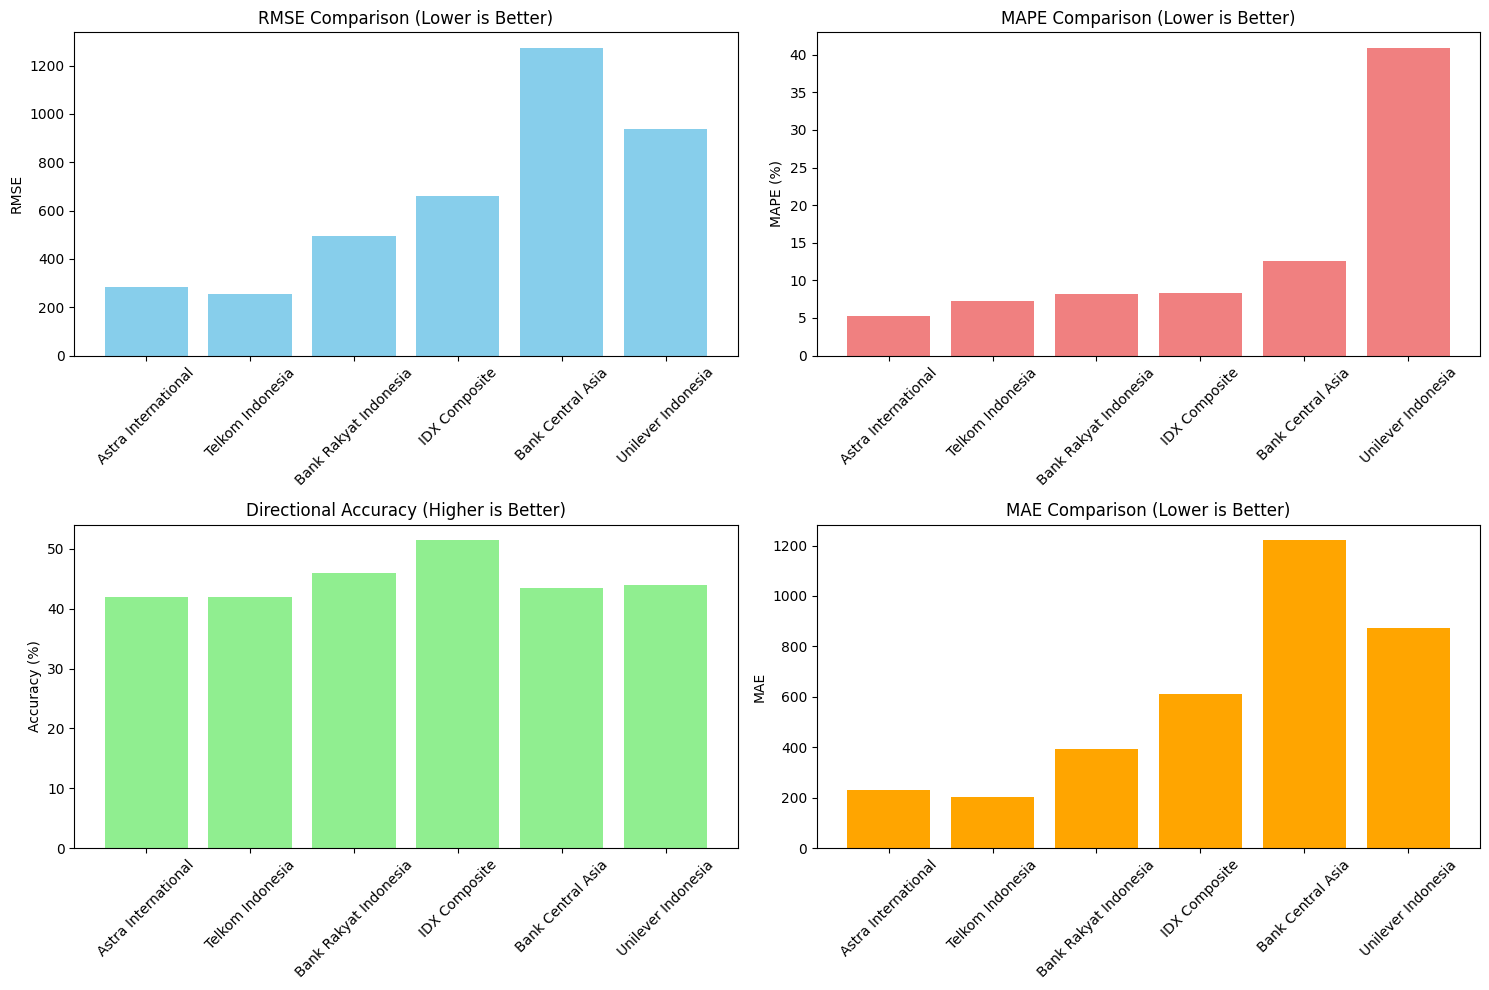

In [27]:
if len(comparison_df_sorted) > 0:
    print("\nGenerating comparison charts...")
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # RMSE comparison
    axes[0,0].bar(comparison_df_sorted['Stock'], comparison_df_sorted['RMSE'], color='skyblue')
    axes[0,0].set_title('RMSE Comparison (Lower is Better)')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # MAPE comparison
    axes[0,1].bar(comparison_df_sorted['Stock'], comparison_df_sorted['MAPE'], color='lightcoral')
    axes[0,1].set_title('MAPE Comparison (Lower is Better)')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Directional Accuracy
    axes[1,0].bar(comparison_df_sorted['Stock'], comparison_df_sorted['Directional_Accuracy'], color='lightgreen')
    axes[1,0].set_title('Directional Accuracy (Higher is Better)')
    axes[1,0].set_ylabel('Accuracy (%)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # MAE comparison
    axes[1,1].bar(comparison_df_sorted['Stock'], comparison_df_sorted['MAE'], color='orange')
    axes[1,1].set_title('MAE Comparison (Lower is Better)')
    axes[1,1].set_ylabel('MAE')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Save plot
    comparison_plot_path = os.path.join(FIGURES_PATH, 'model_comparison.png')
    plt.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
    print(f"Comparison chart saved: {comparison_plot_path}")
    plt.show()

## TRADING SIGNALS GENERATION

In [28]:
if training_results and len(comparison_df_sorted) > 0:
    print("\nTRADING SIGNALS GENERATION")
    print("=" * 60)
    
    # Use best performing stock
    best_symbol = comparison_df_sorted.iloc[0]['Symbol']
    
    if best_symbol in models and best_symbol in stock_data:
        print(f"Generating signals for {STOCKS[best_symbol]} (best performer)")
        
        model = models[best_symbol]
        advisor = advisors[best_symbol]
        data = stock_data[best_symbol]
        
        # Use recent data for demo
        recent_data = data.tail(100)
        
        # Prepare data and get predictions
        X_recent, _ = model.prepare_data(recent_data)
        
        if len(X_recent) > 0:
            # Get predictions for last 30 days
            predictions = model.predict(X_recent[-30:])
            
            # Generate trading signals
            signal_data = recent_data.tail(30)
            signals_df = advisor.generate_signals(signal_data, predictions)
            
            print(f"\nLATEST TRADING SIGNALS for {STOCKS[best_symbol]}")
            print("=" * 80)
            
            # Display signals
            display_cols = ['Date', 'Current_Price', 'Predicted_Price', 'Signal', 'Confidence', 'Reasoning']
            if all(col in signals_df.columns for col in display_cols):
                signals_display = signals_df[display_cols].tail(10).copy()
                
                # Format for display
                signals_display['Current_Price'] = signals_display['Current_Price'].apply(lambda x: f"IDR {x:,.0f}")
                signals_display['Predicted_Price'] = signals_display['Predicted_Price'].apply(lambda x: f"IDR {x:,.0f}")
                signals_display['Confidence'] = signals_display['Confidence'].apply(lambda x: f"{x:.1%}")
                
                print(signals_display.to_string(index=False))
                
                # Save signals
                signals_path = os.path.join(REPORTS_PATH, f'{best_symbol}_trading_signals.csv')
                signals_df.to_csv(signals_path, index=False)
                print(f"\nSignals saved: {signals_path}")
                
                # Signal summary
                signal_counts = signals_df['Signal'].value_counts()
                avg_confidence = signals_df['Confidence'].mean()
                
                print(f"\nSIGNAL SUMMARY:")
                for signal, count in signal_counts.items():
                    print(f"   {signal}: {count} signals")
                print(f"   Average Confidence: {avg_confidence:.1%}")
            else:
                print("Signal generation completed but display format unavailable")
        else:
            print("Insufficient recent data for signal generation")



TRADING SIGNALS GENERATION
Generating signals for Astra International (best performer)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

LATEST TRADING SIGNALS for Astra International
      Date Current_Price Predicted_Price Signal Confidence                                                       Reasoning
2024-12-12     IDR 4,777       IDR 4,745   HOLD      60.0%                                               Positive MA trend
2024-12-13     IDR 4,800       IDR 4,753   HOLD      60.0%                                               Positive MA trend
2024-12-16     IDR 4,800       IDR 4,766   HOLD      60.0%                                               Positive MA trend
2024-12-17     IDR 4,664       IDR 4,780    BUY      75.0%       Predicted price increase: 2.48%; High volume confirmation
2024-12-18     IDR 4,683       IDR 4,786    BUY      70.0%                                 Predicted price increase: 2.20%
2024-12-19     IDR 4,571       IDR 4,775    BUY      70.0%                              

## ENHANCED MODEL TRAINING

In [31]:
try:
    from models.enhanced_trading_advisor import EnhancedTradingAdvisor, train_enhanced_model
    enhanced_available = True
    print("Enhanced trading advisor loaded successfully")
except ImportError:
    enhanced_available = False
    print("Enhanced advisor not available - using basic model only")

# Train enhanced model for best performing stock
if enhanced_available and training_results:
    best_symbol = comparison_df_sorted.iloc[0]['Symbol']
    print(f"\nTRAINING ENHANCED MODEL")
    print("=" * 60)
    print(f"Target stock: {STOCKS[best_symbol]} ({best_symbol})")
    print(f"Baseline MAPE: {comparison_df_sorted.iloc[0]['MAPE']:.2f}%")
    
    try:
        enhanced_advisor, enhanced_metrics = train_enhanced_model(stock_data, best_symbol)
        
        if enhanced_advisor and enhanced_metrics:
            print("\nENHANCED MODEL RESULTS:")
            print("=" * 50)
            print(f"Enhanced MAPE: {enhanced_metrics['MAPE']:.2f}% (vs {comparison_df_sorted.iloc[0]['MAPE']:.2f}% basic)")
            improvement = comparison_df_sorted.iloc[0]['MAPE'] - enhanced_metrics['MAPE']
            print(f"Improvement: {improvement:.2f} percentage points")
            print(f"Directional Accuracy: {enhanced_metrics['Directional_Accuracy']:.2f}%")
            print(f"Win Rate: {enhanced_metrics['Win_Rate']:.2f}%")
            print(f"Total Return: {enhanced_metrics['Total_Return']:.2f}%")
            print(f"Sharpe Ratio: {enhanced_metrics['Sharpe_Ratio']:.2f}")
            print(f"Number of Trades: {enhanced_metrics['Num_Trades']}")
            print(f"Strategy Performance: {enhanced_metrics['Strategy_Performance']}")
            
            # Generate enhanced signals
            print(f"\nGENERATING ADVANCED TRADING SIGNALS")
            print("=" * 50)
            
            data = stock_data[best_symbol]
            enhanced_data = enhanced_advisor.enhanced_feature_engineering(data)
            
            # Get recent predictions for demo
            recent_data = enhanced_data.tail(100)
            X_recent, _ = enhanced_advisor.lstm_model.prepare_data(recent_data)
            
            if len(X_recent) > 0:
                predictions = enhanced_advisor.lstm_model.predict(X_recent[-30:])
                
                # Generate advanced signals with risk management
                advanced_signals = enhanced_advisor.advanced_signal_generation(
                    recent_data.tail(30), predictions
                )
                
                print(f"\nADVANCED TRADING SIGNALS:")
                print("=" * 90)
                
                if not advanced_signals.empty:
                    display_cols = ['Date', 'Signal', 'Confidence', 'Position_Size', 'Stop_Loss', 'Take_Profit', 'Risk_Score']
                    
                    # Check if all columns exist
                    available_cols = [col for col in display_cols if col in advanced_signals.columns]
                    signals_display = advanced_signals[available_cols].tail(10).copy()
                    
                    # Format for display
                    if 'Confidence' in signals_display.columns:
                        signals_display['Confidence'] = signals_display['Confidence'].apply(lambda x: f"{x:.1f}%")
                    if 'Position_Size' in signals_display.columns:
                        signals_display['Position_Size'] = signals_display['Position_Size'].apply(lambda x: f"{x:.1%}")
                    if 'Stop_Loss' in signals_display.columns:
                        signals_display['Stop_Loss'] = signals_display['Stop_Loss'].apply(lambda x: f"IDR {x:,.0f}")
                    if 'Take_Profit' in signals_display.columns:
                        signals_display['Take_Profit'] = signals_display['Take_Profit'].apply(lambda x: f"IDR {x:,.0f}")
                    if 'Risk_Score' in signals_display.columns:
                        signals_display['Risk_Score'] = signals_display['Risk_Score'].apply(lambda x: f"{x:.1f}")
                    
                    print(signals_display.to_string(index=False))
                    
                    # Save enhanced results
                    enhanced_signals_path = os.path.join(REPORTS_PATH, f'{best_symbol}_enhanced_signals.csv')
                    advanced_signals.to_csv(enhanced_signals_path, index=False)
                    print(f"\nEnhanced signals saved: {enhanced_signals_path}")
                    
                    # Signal distribution
                    if 'Signal' in advanced_signals.columns:
                        signal_dist = advanced_signals['Signal'].value_counts()
                        print(f"\nSignal Distribution:")
                        for signal, count in signal_dist.items():
                            print(f"  {signal}: {count}")
                    
                    # Risk analysis summary
                    if 'Position_Size' in advanced_signals.columns and 'Risk_Score' in advanced_signals.columns:
                        avg_position_size = advanced_signals['Position_Size'].mean()
                        avg_risk_score = advanced_signals['Risk_Score'].mean()
                        print(f"\nRisk Analysis:")
                        print(f"  Average Position Size: {avg_position_size:.1%}")
                        print(f"  Average Risk Score: {avg_risk_score:.1f}")
                    
                    # Backtest summary
                    try:
                        backtest_results = enhanced_advisor.backtest_strategy(recent_data.tail(30), advanced_signals)
                        print(f"\nBacktest Results (Last 30 Days):")
                        print(f"  Win Rate: {backtest_results['win_rate']:.1%}")
                        print(f"  Total Return: {backtest_results['total_return']:.2%}")
                        print(f"  Number of Trades: {backtest_results['num_trades']}")
                    except Exception as e:
                        print(f"Backtest calculation: {str(e)}")
                else:
                    print("No advanced signals generated")
            else:
                print("Insufficient data for enhanced signal generation")
        else:
            print("Enhanced model training failed")
            
    except Exception as e:
        print(f"Enhanced model error: {str(e)}")
        enhanced_available = False

Enhanced trading advisor loaded successfully

TRAINING ENHANCED MODEL
Target stock: Astra International (ASII)
Baseline MAPE: 5.22%
   Training enhanced model with 9 features...
Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.5545 - mae: 0.5881 - learning_rate: 0.0010
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2384 - mae: 0.3771 - learning_rate: 0.0010
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1700 - mae: 0.3192 - learning_rate: 0.0010
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1372 - mae: 0.2919 - learning_rate: 0.0010
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1129 - mae: 0.2628 - learning_rate: 0.0010
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1031 - mae: 0.2508 - learning_rate: 0.0010
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0897 - mae: 0.2332 - learning_rate: 0.0010
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0771 - mae: 0.2178 - learning_ra

## COMPLETE MODEL COMPARISON

In [32]:
print('\n' + '=' * 80)
print('              COMPLETE MODEL COMPARISON')
print('=' * 80)

if training_results:
    print(f"\nBasic LSTM Results:")
    print(f"  Best Stock: {comparison_df_sorted.iloc[0]['Stock']}")
    print(f"  MAPE: {comparison_df_sorted.iloc[0]['MAPE']:.2f}%")
    print(f"  Directional Accuracy: {comparison_df_sorted.iloc[0]['Directional_Accuracy']:.2f}%")
    print(f"  Models trained: {len(training_results)}")

    if enhanced_available and 'enhanced_metrics' in locals() and enhanced_metrics:
        print(f"\nEnhanced Model Results:")
        print(f"  MAPE Improvement: {comparison_df_sorted.iloc[0]['MAPE'] - enhanced_metrics['MAPE']:.2f} percentage points")
        print(f"  Win Rate: {enhanced_metrics['Win_Rate']:.1f}%")
        print(f"  Strategy Return: {enhanced_metrics['Total_Return']:.1f}%")
        print(f"  Risk Management: Advanced (Position sizing, Stop-loss, Volatility analysis)")
        
        # Performance comparison
        print(f"\nPerformance Comparison:")
        print(f"  Basic Model:    MAPE {comparison_df_sorted.iloc[0]['MAPE']:.2f}%, Accuracy {comparison_df_sorted.iloc[0]['Directional_Accuracy']:.1f}%")
        print(f"  Enhanced Model: MAPE {enhanced_metrics['MAPE']:.2f}%, Win Rate {enhanced_metrics['Win_Rate']:.1f}%")
        
        if enhanced_metrics['MAPE'] < comparison_df_sorted.iloc[0]['MAPE']:
            print(f"  🎯 Enhanced model shows superior performance!")
        else:
            print(f"  📊 Basic model remains competitive")


              COMPLETE MODEL COMPARISON

Basic LSTM Results:
  Best Stock: Astra International
  MAPE: 5.22%
  Directional Accuracy: 41.89%
  Models trained: 6

Enhanced Model Results:
  MAPE Improvement: 1.79 percentage points
  Win Rate: 64.5%
  Strategy Return: 11.7%
  Risk Management: Advanced (Position sizing, Stop-loss, Volatility analysis)

Performance Comparison:
  Basic Model:    MAPE 5.22%, Accuracy 41.9%
  Enhanced Model: MAPE 3.43%, Win Rate 64.5%
  🎯 Enhanced model shows superior performance!


## FINAL SUMMARY AND FILE CHECK

In [33]:
print('\n' + '=' * 80)
print('              TRAINING COMPLETED SUCCESSFULLY!')
print('=' * 80)

print(f'\nSUMMARY:')
print(f'   Models trained: {len(training_results)}')
print(f'   Total stocks: {len(STOCKS)}')
print(f'   Features used: {len(FEATURES)}')
print(f'   Sequence length: {SEQUENCE_LENGTH}')

print(f'\nOUTPUT LOCATIONS:')
print(f'   Models: {MODEL_PATH}/')
print(f'   Reports: {REPORTS_PATH}/')
print(f'   Figures: {FIGURES_PATH}/')

if training_results:
    best_stock = comparison_df_sorted.iloc[0]
    print(f'\nBEST MODEL: {best_stock["Stock"]} (MAPE: {best_stock["MAPE"]:.2f}%)')
    print(f'   Ready for deployment and real-time predictions!')

# Check generated files
print('\nCHECKING GENERATED FILES:')
print('=' * 50)

# Model files
model_files = glob.glob(os.path.join(MODEL_PATH, '*'))
print(f'Model files ({len(model_files)}):')
for file in model_files:
    if os.path.isfile(file):
        size = os.path.getsize(file) / (1024*1024)  # MB
        print(f'  ✓ {os.path.basename(file)}: {size:.1f} MB')

# Report files
report_files = glob.glob(os.path.join(REPORTS_PATH, '*.csv'))
print(f'Report files ({len(report_files)}):')
for file in report_files:
    print(f'  ✓ {os.path.basename(file)}')

# Figure files
figure_files = glob.glob(os.path.join(FIGURES_PATH, '*.png'))
print(f'Figure files ({len(figure_files)}):')
for file in figure_files:
    print(f'  ✓ {os.path.basename(file)}')



              TRAINING COMPLETED SUCCESSFULLY!

SUMMARY:
   Models trained: 6
   Total stocks: 6
   Features used: 6
   Sequence length: 60

OUTPUT LOCATIONS:
   Models: ../models/saved_models/
   Reports: ../reports/
   Figures: ../reports/figures/

BEST MODEL: Astra International (MAPE: 5.22%)
   Ready for deployment and real-time predictions!

CHECKING GENERATED FILES:
Model files (18):
  ✓ ASII_model_feature_scaler.pkl: 0.0 MB
  ✓ ASII_model_model.h5: 0.5 MB
  ✓ ASII_model_target_scaler.pkl: 0.0 MB
  ✓ BBCA_model_feature_scaler.pkl: 0.0 MB
  ✓ BBCA_model_model.h5: 0.5 MB
  ✓ BBCA_model_target_scaler.pkl: 0.0 MB
  ✓ BBRI_model_feature_scaler.pkl: 0.0 MB
  ✓ BBRI_model_model.h5: 0.5 MB
  ✓ BBRI_model_target_scaler.pkl: 0.0 MB
  ✓ JKSE_model_feature_scaler.pkl: 0.0 MB
  ✓ JKSE_model_model.h5: 0.5 MB
  ✓ JKSE_model_target_scaler.pkl: 0.0 MB
  ✓ TLKM_model_feature_scaler.pkl: 0.0 MB
  ✓ TLKM_model_model.h5: 0.5 MB
  ✓ TLKM_model_target_scaler.pkl: 0.0 MB
  ✓ UNVR_model_feature_scaler.p